# Analyse APL — Thiérache du Centre (2022–2023)

**Objectif** : vérifier si la Thiérache du Centre est réellement en « désert » de médecins généralistes, en s’appuyant sur l’**APL** (accessibilité potentielle localisée).

**Données** : `apl_generalistes_2022_2023_Thierache.csv` (commune × année) – colonnes clés :  
- `apl_generalistes` (plus c’est grand, mieux c’est),  
- `pop_standardisee` (poids pour les agrégations supra-communales),  
- `is_thierache_centre` (True/False).


### Rappel lecture APL (DREES, résumé)
- Valeur = *nombre de consultations/visites accessibles par habitant standardisé et par an*.  
- Agrégation (EPCI, département…) : **moyenne pondérée par `pop_standardisee`**.  
- Comparaison **entre années** : interprétation **prudente** (besoins en soins évoluent avec l'âge de la population).

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

CSV_PATH = '../../../data/preprocessed/apl-thierache-centre/apl_generalistes_2022_2023_Thierache.csv'

apl = pd.read_csv(CSV_PATH)
apl['code_insee'] = apl['code_insee'].astype(str).str.zfill(5)
apl.head()

/tmp/ipykernel_115543/742415266.py:7: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  apl = pd.read_csv(CSV_PATH)


,annee,code_insee,commune,is_thierache_centre,apl_generalistes,apl_generalistes_moins65,pop_standardisee,pop_totale
0,2022,01001,L'Abergement-Clémenciat,False,1.890,1.828,810.855,806
1,2022,01002,L'Abergement-de-Varey,False,2.649,2.059,250.962,262
2,2022,01004,Ambérieu-en-Bugey,False,3.646,2.880,14002.685,14288
3,2022,01005,Ambérieux-en-Dombes,False,3.978,3.959,1733.232,1782
4,2022,01006,Ambléon,False,0.926,0.796,121.438,113


In [29]:
apl_2022 = apl[apl['annee'] == 2022].copy()
apl_2023 = apl[apl['annee'] == 2023].copy()

## Comparaison 2022 — Thiérache vs reste de la France (par commune)

/tmp/ipykernel_115543/3164838447.py:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([thierache_2022, france_2022], labels=['Thiérache du Centre', 'Reste de la France'])


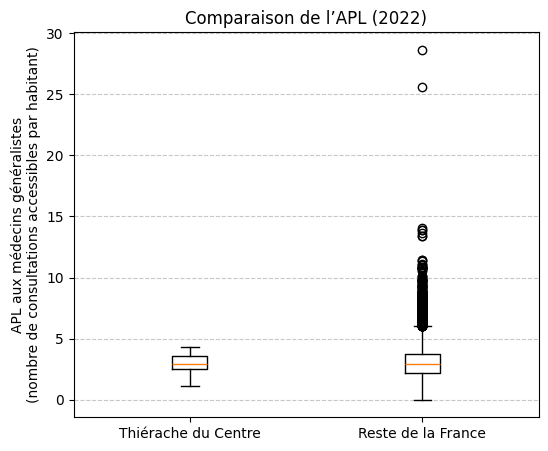

Moyenne Thiérache (2022): 2.98
Moyenne France (2022):    3.00
Médiane France (2022):    2.94


In [37]:
thierache_2022 = apl_2022.loc[apl_2022['is_thierache_centre'], 'apl_generalistes'].dropna()
france_2022 = apl_2022['apl_generalistes'].dropna()

plt.figure(figsize=(6,5))
plt.boxplot([thierache_2022, france_2022], labels=['Thiérache du Centre', 'Reste de la France'])
plt.ylabel('APL aux médecins généralistes\n(nombre de consultations accessibles par habitant)')
plt.title("Comparaison de l’APL (2022)")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

print(f"Moyenne Thiérache (2022): {thierache_2022.mean():.2f}")
print(f"Moyenne France (2022):    {france_2022.mean():.2f}")
print(f"Médiane France (2022):    {np.median(france_2022):.2f}")

## APL moyen pondéré (règle DREES) — EPCI Thiérache vs France (2022)

In [31]:
def apl_pond(df):
    num = (df['apl_generalistes'] * df['pop_standardisee']).sum()
    den = df['pop_standardisee'].sum()
    return num / den

## Où se situe la Thiérache?

In [32]:

apl_thierache_pond_2022 = apl_pond(apl_2022[apl_2022['is_thierache_centre']])
apl_france_pond_2022 = apl_pond(apl_2022)

print(f"APL pondéré 2022 — Thiérache : {apl_thierache_pond_2022:.2f} | France : {apl_france_pond_2022:.2f}")

APL pondéré 2022 — Thiérache : 3.12 | France : 3.79


## APL moyen pondéré (règle DREES) — EPCI Thiérache vs France (2023)

In [33]:

apl_thierache_pond_2023 = apl_pond(apl_2023[apl_2023['is_thierache_centre']])
apl_france_pond_2023 = apl_pond(apl_2023)

print(f"APL pondéré 2023 — Thiérache : {apl_thierache_pond_2023:.2f} | France : {apl_france_pond_2023:.2f}")

APL pondéré 2023 — Thiérache : 3.07 | France : 3.74


In [39]:
import numpy as np
import matplotlib.pyplot as plt

def plot_thierache_position(df, title_year=None, exclude_thierache_from_france=True):
    """
    df: DataFrame déjà filtré sur une année (ex: apl_2022 ou apl_2023)
    exclude_thierache_from_france: True -> le boxplot "France" exclut la Thiérache (reco)
    """
    required = {"apl_generalistes", "pop_standardisee", "is_thierache_centre"}
    if not required.issubset(df.columns):
        raise ValueError(f"Colonnes manquantes: {required - set(df.columns)}")

    fr = (df.loc[~df["is_thierache_centre"], "apl_generalistes"].dropna()
          if exclude_thierache_from_france else df["apl_generalistes"].dropna())

    th = df.loc[df["is_thierache_centre"], "apl_generalistes"].dropna()

    apl_th = apl_pond(df[df["is_thierache_centre"]])

    fig, ax = plt.subplots(figsize=(7,5))
    ax.boxplot([fr], labels=["France (communes)"])

    if len(th):
        x = np.ones(len(th)) + (np.random.rand(len(th)) - 0.5)*0.06
        ax.scatter(x, th, s=12, alpha=0.6, label="Communes Thiérache")

    ax.axhline(apl_th, linestyle="--", linewidth=1.5,
               label=f"Thiérache (pondéré) = {apl_th:.2f}")

    ax.set_ylabel("APL médecins généralistes\n(nb de consultations/visites accessibles par habitant standardisé)")
    title = f"Position de la Thiérache vs France — {title_year}" if title_year else "Position de la Thiérache vs France"
    ax.set_title(title)
    ax.grid(axis="y", linestyle="--", alpha=0.5)
    ax.legend(loc="lower right")
    plt.show()


/tmp/ipykernel_115543/800432942.py:21: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot([fr], labels=["France (communes)"])


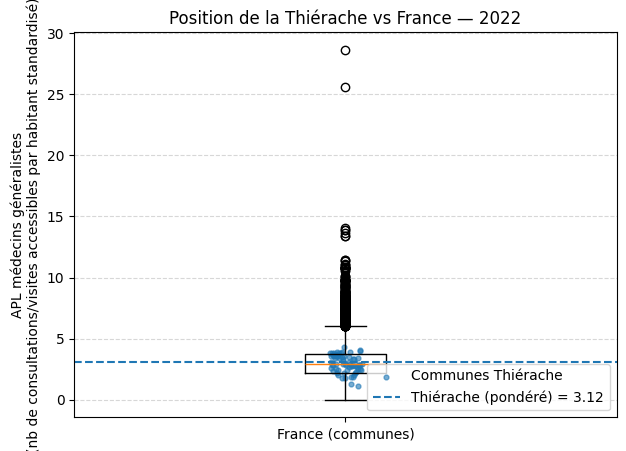

In [40]:
plot_thierache_position(apl_2022, title_year=2022)

/tmp/ipykernel_115543/800432942.py:21: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot([fr], labels=["France (communes)"])


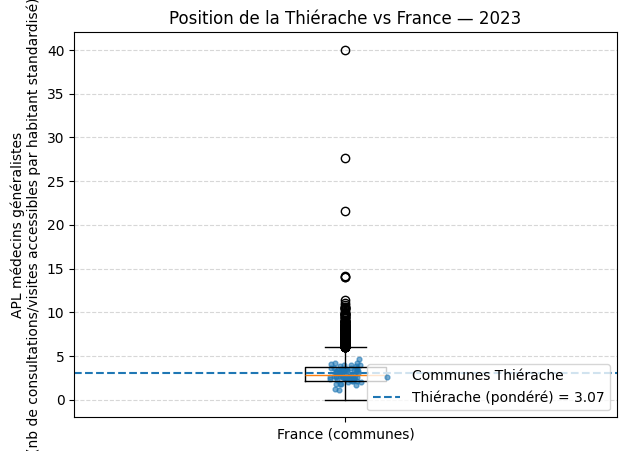

In [41]:
plot_thierache_position(apl_2023, title_year=2023)

# Première conclusion

La Thiérache du Centre **n’est pas alarmante** en APL : elle n’est **pas parmi les meilleures**, mais **pas en queue extrême** non plus.
On regarde aussi l’évolution **2022 → 2023** pour situer la dynamique.

**Évolution 2022 → 2023 (APL pondéré, règle DREES)**

* Thiérache du Centre : **3,12 → 3,07** (Δ = **−0,05** ≈ −1,6 %)
* France entière : **3,79 → 3,74** (Δ = **−0,05** ≈ −1,3 %)

**Lecture rapide**

* Léger **recul partout**, du même ordre de grandeur.
* L’**écart** avec la moyenne nationale reste **quasi identique** (≈ −0,67 pt en 2022 comme en 2023).
* La Thiérache reste **un cran en dessous de la moyenne**, mais **ne décroche pas** par rapport au reste du pays.

**Prudence (rappel DREES)**

* Agrégation supra-communale = **moyenne pondérée par `pop_standardisee`** (ce qui est fait ici).
* La standardisation permet la **comparaison entre territoires à une date**, mais **ne corrige pas** l’évolution des **besoins** (vieillissement) d’une année à l’autre : le Δ reflète un **signal mixte** (*offre* + *besoins*).
* Pour isoler davantage l’**offre**, on peut recalculer 2023 avec des **poids constants 2022**.
